In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 1.jpg to 1.jpg
User uploaded file "1.jpg" with length 251689 bytes


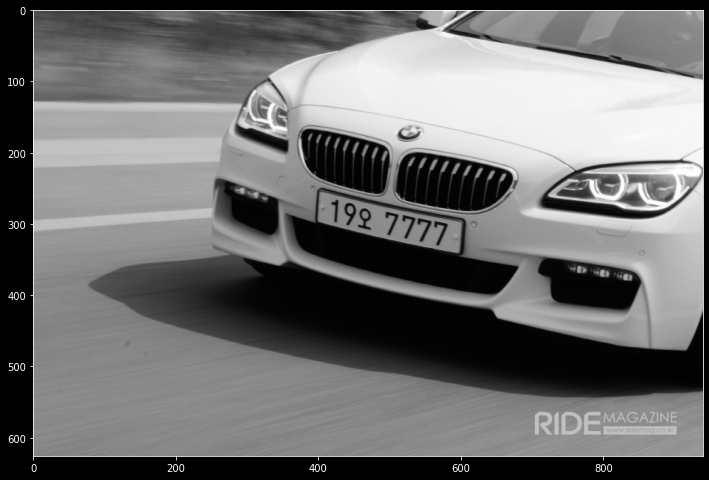

In [5]:
img_ori = cv2.imread('1.jpg')
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

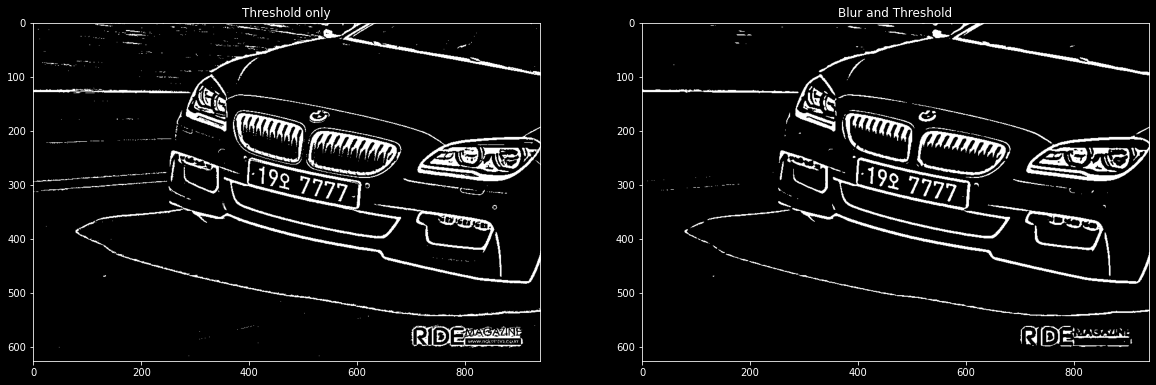

In [6]:

# threshold only
img_thresh = cv2.adaptiveThreshold(
    gray, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

# blur and threshold
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Threshold only')
plt.imshow(img_thresh, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

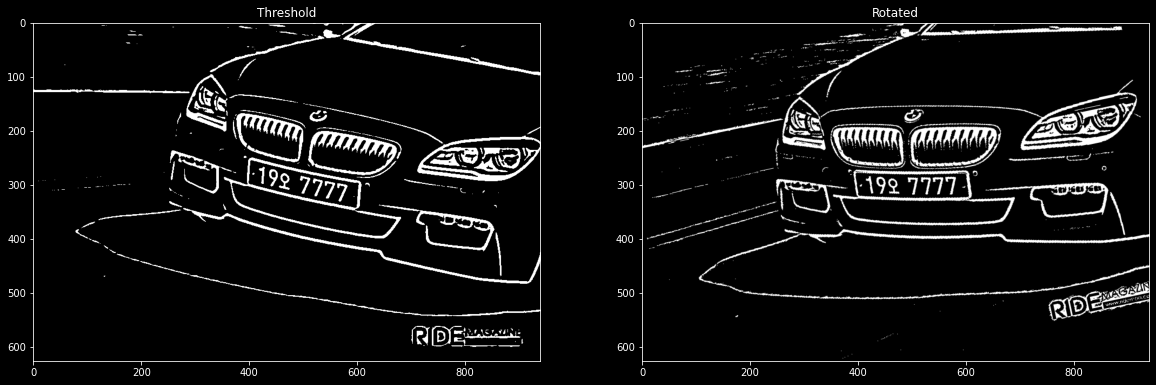

In [7]:
plate_cx, plate_cy = 508.75, 300.5
width, height = 940, 626 
plate_width, plate_height = 188.5, 49
angle = 11.9565

rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Threshold')
plt.imshow(img_blur_thresh, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Rotated')
plt.imshow(img_rotated, cmap='gray')

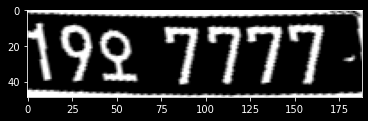

In [8]:
img_cropped = cv2.getRectSubPix(
    img_rotated, 
    patchSize=(int(plate_width), int(plate_height)), 
    center=(int(plate_cx), int(plate_cy))
)

plt.imshow(img_cropped, cmap='gray')